# GradCAM visualisations

In [86]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms.functional import normalize, resize, to_pil_image
from skimage.io import imread
from skimage.transform import resize
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from skimage.io import imread
from skimage.io import imsave

from prediction.chexpert_disease import CheXpertDataModule, ResNet, DenseNet

In [87]:
# Parameters
img_size = 128
model_path_d = "prediction/chexpert/disease/models/densenet-all_128/version_0/checkpoints/epoch=9-step=5090.ckpt"
model_path_s = "prediction/chexpert/sex/models/densenet-all_128/version_0/checkpoints/epoch=13-step=7126.ckpt"
model_path_r = "prediction/chexpert/race/models/densenet-all_128/version_2/checkpoints/epoch=10-step=5599.ckpt"
model_type = "DenseNet"
layer = "model.features.denseblock4.denselayer16" # For resnet: "model.layer4"
patient = "patient64626"
image_paths = [
    f"/Users/felixkrones/python_projects/data/ChestXpert/preproc_128x128_len_202_cropped/{patient}_study1_view1_frontal.jpg",
    f"/Users/felixkrones/python_projects/data/ChestXpert/preproc_128x128_len_202_cropped_fake_filtered_Frontal_bs_128_lr_0.0002_nz_100_disc_0.1_sim_4.0_prev_0.3_pred_0.3_cyc_1/{patient}_study1_view1_frontal.jpg",
]
out_dir = ('/').join(model_path_d.split("/")[:-3] + ["gradcam/"])

In [88]:
patient_list = [
#"patient64626",
#"patient64669",
#"patient64671",
]

#image_paths = []
#for patient in patient_list:
#    image_paths.append(f"/Users/felixkrones/python_projects/data/ChestXpert/preproc_128x128_len_202_cropped/{patient}_study1_view1_frontal.jpg")
#    image_paths.append(f"/Users/felixkrones/python_projects/data/ChestXpert/preproc_128x128_len_202_cropped_fake_filtered_Frontal_bs_128_lr_0.0002_nz_100_disc_0.1_sim_4.0_prev_0.3_pred_0.3_cyc_1/{patient}_study1_view1_frontal.jpg")

In [89]:
# Get data
images = []
for image in image_paths:
    image = imread(image).astype(np.float32)
    image = torch.from_numpy(image)
    if len(image.shape) == 2:
        image = image.unsqueeze(0)
    if image.shape[2] == 3:
        image = image.permute(2, 0, 1)
    elif image.shape[0] == 3:
        image = image
    elif image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    else:
        raise ValueError(f"Image shape {image.shape} not supported.")
    images.append(image)

# Convert list of images to tensor batch
images = torch.from_numpy(np.stack(images))
images.shape

torch.Size([2, 3, 128, 128])

(-0.5, 127.5, 127.5, -0.5)

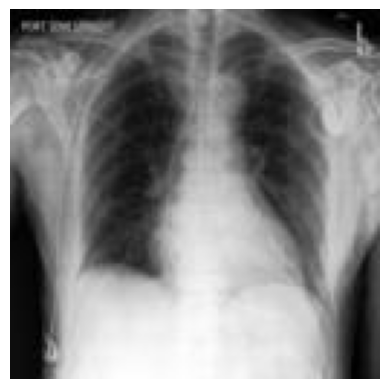

In [90]:
# Show last image
plt.imshow(images[0].permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis("off")

(-0.5, 127.5, 127.5, -0.5)

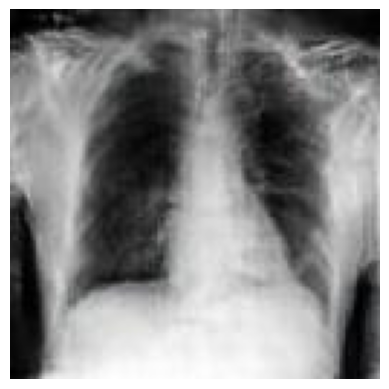

In [91]:
plt.imshow(images[1].permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis("off")

In [99]:
# Run GradCAM
# white: 0, asian: 1, black: 2
# male: 0, female: 1
# 3 = Lung Opacity, 13 = Support Device
class_id_d = 3
class_id_r = 1
class_id_s = 0

model_d = eval(model_type).load_from_checkpoint(model_path_d, num_classes=14)
model_s = eval(model_type).load_from_checkpoint(model_path_s, num_classes=2)
model_r = eval(model_type).load_from_checkpoint(model_path_r, num_classes=3)
model_d.eval()
model_s.eval()
model_r.eval()
cam_extractor_d = GradCAM(model_d, layer)
cam_extractor_s = GradCAM(model_s, layer)
cam_extractor_r = GradCAM(model_r, layer)
outs_d = model_d(images)
outs_s = model_s(images)
outs_r = model_r(images)
cams_d = cam_extractor_d(class_id_d, outs_d)[0]
cams_r = cam_extractor_r(class_id_r, outs_r)[0]
cams_s = cam_extractor_s(class_id_s, outs_s)[0]

In [100]:
nn.Sigmoid()(outs_d)[:, [3,13]]

tensor([[0.1492, 0.8547],
        [0.4539, 0.8872]], grad_fn=<IndexBackward0>)

In [101]:
nn.Softmax()(outs_r)[:, ]

/var/folders/__/rxwd5ql13vz5lp1s1xlp8cg40000gn/T/ipykernel_13768/1674420102.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax()(outs_r)[:, ]


tensor([[0.1063, 0.8891, 0.0046],
        [0.9675, 0.0306, 0.0019]], grad_fn=<SliceBackward0>)

In [102]:
nn.Softmax()(outs_s)[:, ]

/var/folders/__/rxwd5ql13vz5lp1s1xlp8cg40000gn/T/ipykernel_13768/366568400.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax()(outs_s)[:, ]


tensor([[9.9965e-01, 3.4802e-04],
        [9.6655e-01, 3.3452e-02]], grad_fn=<SliceBackward0>)

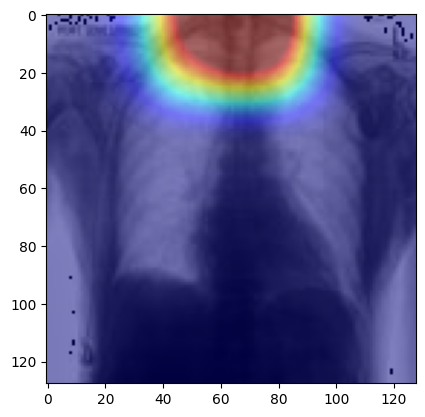

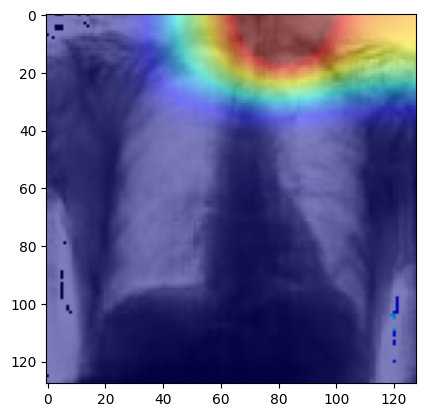

In [103]:
# Overlayed on the image
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for cam, img, path in zip(cams_d, images, image_paths):
  result = overlay_mask(to_pil_image(img.squeeze()), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.show()
  if "fake" in path:
    result.save(out_dir + f'{model_path_d.split("/")[2]}_class_{class_id_d}_fake_{path.split("/")[-1]}')
  else:
    result.save(out_dir + f'{model_path_d.split("/")[2]}_class_{class_id_d}_{path.split("/")[-1]}')

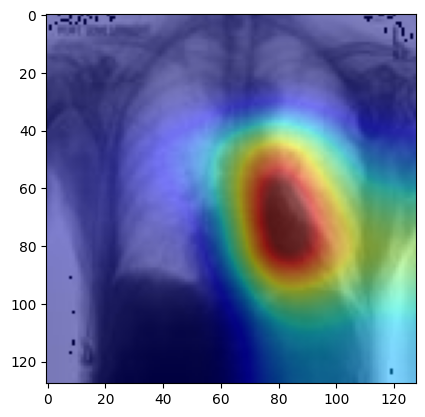

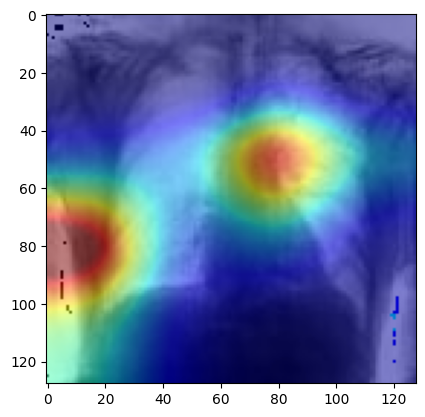

In [97]:
# Overlayed on the image
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for cam, img, path in zip(cams_s, images, image_paths):
  result = overlay_mask(to_pil_image(img.squeeze()), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.show()
  if "fake" in path:
    result.save(out_dir + f'{model_path_s.split("/")[2]}_class_{class_id_s}_fake_{path.split("/")[-1]}')
  else:
    result.save(out_dir + f'{model_path_s.split("/")[2]}_class_{class_id_s}_{path.split("/")[-1]}')

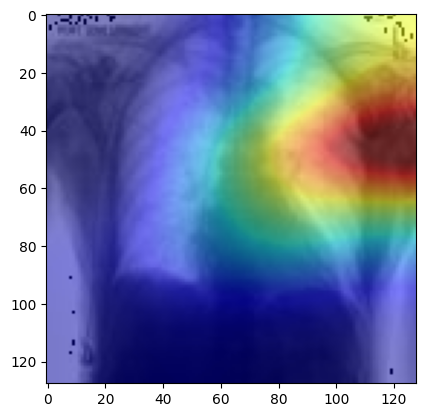

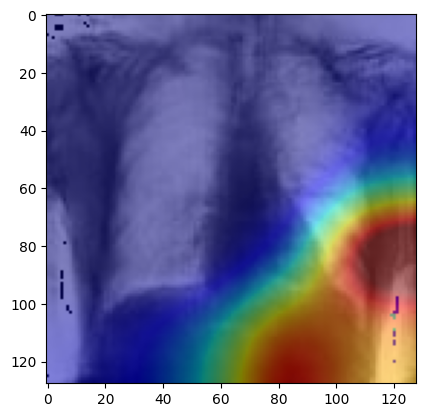

In [98]:
# Overlayed on the image
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for cam, img, path in zip(cams_r, images, image_paths):
  result = overlay_mask(to_pil_image(img.squeeze()), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.show()
  if "fake" in path:
    result.save(out_dir + f'{model_path_r.split("/")[2]}_class_{class_id_r}_fake_{path.split("/")[-1]}')
  else:
    result.save(out_dir + f'{model_path_r.split("/")[2]}_class_{class_id_r}_{path.split("/")[-1]}')